In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw
from scipy.optimize import curve_fit
from scipy.stats import chi2

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    print cruise
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments

def getscales(data, segments, var, var2, offset):
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
    despiked = pd.DataFrame()
    
    for i in range(1, len(segments)+1):
        a = segments['start'][i]
        b = segments['end'][i]
        
        tmp = data[a:b]
        segnumber = i
        cruise = segments['cruise'][i]
        aa = data['x'][a]
        bb = data['x'][b]
        
        
        tmp = interpdata(tmp, aa, bb, var)
        # add a step for despiking the data using 5 point median
        seglength = len(tmp)
        tmp4 = despike(tmp, var2)
        
        # change tmp to tmp4 to analyse the despiked version
        tmp1 = detrenddata(tmp, var2) 
            
        # start the decorrelation calculation here
        tmp2, tmp3 = fft_data(tmp1, var2, cruise, segnumber)
            # append the scale data for each segment to the scales dataframe
        
        if i == 1 :
            scales = scales.append(tmp2)
            seg_fft = seg_fft.append(tmp3)
            despiked = despiked.append(tmp4)
        else:
            scales = pd.concat([scales, tmp2], axis=0)
            despiked = pd.concat([despiked, tmp4], axis = 0)
            seg_fft = seg_fft.merge(tmp3, left_on='wavenumber', right_on='wavenumber', how='outer')

        del tmp2, tmp1, tmp3, tmp4

            
    scales['number'] = range(len(scales))
    scales = scales.set_index(['number'])    
    return scales, seg_fft, despiked
        
        
def fft_data(detdata, var, cruise, segnumber):
    # initialize the dataframe for the scales
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
   
    # set the length of the segments to look at
    ll = len(detdata) # length of decorrelation segment
    
    
    scales['lat'] = (detdata['lat'].values)[ll/2]
    scales['lon'] = (detdata['lon'].values)[ll/2]
    scales['depth_mid'] = (detdata['depth'].values)[ll/2]
    scales['dcoast_mean'] = np.nanmean(detdata['dcoast'].values)
    scales['dcoast_mid'] = (detdata['dcoast'].values)[ll/2]
    scales['depth_mean'] = np.nanmean(detdata['depth'].values)
    scales['cruise'] = cruise
    scales['segment #'] = segnumber
    print segnumber, ll, cruise, (detdata['lat'].values)[ll/2], (detdata['lon'].values)[ll/2], np.mean(detdata['dom_group'].values)
    
    
    freq = np.fft.fftfreq(ll, 1.0)
    seg_fft['wavenumber'] = freq
        
    for v in var:

        tmp = detdata[v]

        # initialize array for the results, needs to b 3 cols, length t
        data = tmp
        yf = np.fft.fft(data*np.hanning(len(data)))
                                         
        # append to the scales dataframe
        v2 = '%s_%d' % (v, segnumber)
       
        seg_fft[v2] = yf**2
        del yf
            
    return scales, seg_fft
        

def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata

def despike(tmp, var):
    # use 5 point median to despike data
    despiked = pd.DataFrame()
    n= 5
    nn = len(tmp)

    for v in var:
        vv = tmp[v].values
        tmp1 = np.zeros(nn-4)
        for m in range(nn-4):
            tmp1[m] = np.median(vv[[m, m+1, m+3, m+4]])
        despiked[v] = tmp1

        del tmp1
        
    despiked['x'] = tmp['x'][2:len(despiked)-2]
    despiked['lon'] = tmp['lon'][2:len(despiked)-2]
    despiked['lat'] = tmp['lat'][2:len(despiked)-2]
    despiked['depth'] = tmp['depth'][2:len(despiked)-2]
    despiked['dcoast'] = tmp['dcoast'][2:len(despiked)-2]
    despiked['dom_group'] = tmp['dom_group'][2:len(despiked)-2]
    return despiked
        
def detrenddata(track, var2):
    # take the interpolated data and remove the large scale trend, e.g. apply a high pass filter.
    detdata = pd.DataFrame()
    detdata['x'] = track['x']
    detdata['lon'] = track['lon']
    detdata['lat'] = track['lat']
    detdata['depth'] = track['depth']
    detdata['dcoast'] = track['dcoast']
    detdata['dom_group'] = track['dom_group']
    

    # First, design the Butterworth filter
    N  = 3    # Filter order
    cutoff = 250. # length scale for cutoff
    Wn = 1/cutoff # Cutoff wavelength, normalised to n
    B, A = signal.butter(N, Wn, 'low', output='ba')
    
    # Second, apply the filter to each of the variables
    
    for v in var2:
        detdata[v] = track[v] - signal.filtfilt(B,A, track[v])
    return detdata
    

def fftbin(fft, bins, bin_mid):
    
    y = 1/(np.abs(fft['wavenumber'].values))
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
    
    var = fft.columns
    for v in var:
        
        z = np.abs(fft[v].values) 
        
        digitized = np.digitize(y, bins)
        bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

        bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
        bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
        binned[v] = bin_means
        
        v1 = '%s_sd' % v
        binned[v1] = bin_std

    return binned   

def most_abundant(row):
    if row['pico'] > row['synecho'] and row['pico'] > row['picoeuk']: 
        return 1
    if row['synecho'] > row['pico'] and row['synecho'] > row['picoeuk']: 
        return 2
    if row['picoeuk'] > row['synecho'] and row['picoeuk'] > row['pico']: 
        return 3
    


In [3]:
# import mega dataset
filePath = '/Users/archie/Google Drive/seaflow_data/KM1_abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')
print data.columns

filePath = '/Users/archie/Google Drive/seaflow_data/KM1_chl.csv'
chl = pd.read_csv(filePath, sep=',')

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)


Index([u'Unnamed: 0', u'cruise', u'file_time', u'opp_evt_ratio', u'flow_rate',
       u'beads', u'picoeuk', u'prochloro', u'synecho', u'unknown', u'cocco',
       u'ts', u'file_duration', u'pico', u'Unnamed: 0.1', u'tot_chl',
       u'file_time_r', u'Unnamed: 0.1', u'file_duration_r', u'lat', u'lon',
       u'conductivity', u'salinity', u'ocean_tmp', u'par', u'bulk_red',
       u'stream_pressure', u'flow_rate_r', u'event_rate', u'avg_chl',
       u'avg_pe', u'avg_fsc', u'density', u'lon_e', u'dx', u'x', u'sds_time',
       u'file_time_r.1', u'opp.evt'],
      dtype='object')


In [4]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = pd.merge(data, chl, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk', 'chl']]
#clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean['dom_group']= clean.apply(most_abundant, axis =1)
clean = distance(clean)


['KiloMoana_1']


In [5]:
# split the data into continuous segments at least 200 km long with no gaps bigger than 20 km.
segments = tracks(clean)

# now do the length scale analysis
# interpolate the data, detrend it using the low pass filter, then find the decorrelation scales
# loop over each segment
var = ['lat', 'lon', 'chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk','depth', 'dcoast', 'dom_group']
var2 = ['chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk']

scales, seg_fft, despiked = getscales(clean, segments, var, var2, 200)
#seg_fft = seg_fft.sort(['wavenumber'], ascending=True)

1 296 KiloMoana_1 49.1307312456 -132.681922556 2.79186190742
2 291 KiloMoana_1 49.4296402902 -136.667178658 3.0
3 299 KiloMoana_1 49.8436847619 -142.731487395 3.0
4 373 KiloMoana_1 49.9928315027 -147.390039472 3.0
5 433 KiloMoana_1 48.0543939402 -149.999811521 3.0
6 243 KiloMoana_1 42.7801217713 -150.000177164 1.75161047851
7 277 KiloMoana_1 40.2438169439 -149.999943769 1.00698359204
8 433 KiloMoana_1 36.9474431545 -150.000811491 1.00918229182
9 480 KiloMoana_1 28.4154072744 -151.595548217 1.0


In [6]:
### try fitting explonential curves to the fft results

# print seg_fft.columns

# def fx(x):
#     return np.log10(np.abs(x))
# log_fft = seg_fft.apply(fx)
# print log_fft

def line(x, a, b):
    return b * x + a

var = seg_fft.columns[1::]

for i in var:
    x = np.abs(seg_fft['wavenumber'].values)
    y = np.abs(seg_fft[i].values)
    
    # need to remove rows with NaN of Inf from x and y
    x = np.log10(x[~np.isnan(y)])
    y = np.log10(y[~np.isnan(y)])
    
    y = y[~np.isinf(x)]
    x = x[~np.isinf(x)]
    
    x = x[~np.isinf(y)]
    y = y[~np.isinf(y)]
    
    if len(x) > 1:
        popt, pcov = curve_fit(line, x, y)
        print i, ", slope = ", popt[1], "+/-", pcov[1,1]**0.5
    
    # save out the slopes to a dataframe...


chl_1 , slope =  -2.68372448719 +/- 0.089118664908
ocean_tmp_1 , slope =  -2.22790065376 +/- 0.0760814981637
salinity_1 , slope =  -2.6774372526 +/- 0.0721403798201
density_1 , slope =  -2.50173190562 +/- 0.0893334657754
synecho_1 , slope =  -1.83634252815 +/- 0.0721759238693
picoeuk_1 , slope =  -1.73324635402 +/- 0.0745006682715
chl_2 , slope =  -2.97948393613 +/- 0.0892684316674
ocean_tmp_2 , slope =  -2.48460964391 +/- 0.0833699448962
salinity_2 , slope =  -2.70693393756 +/- 0.0705650573152
density_2 , slope =  -2.48148832012 +/- 0.0738424359315
synecho_2 , slope =  -1.41988884985 +/- 0.090062850561
picoeuk_2 , slope =  -1.70988900189 +/- 0.0868597810555
chl_3 , slope =  -2.29975593406 +/- 0.0819196048526
ocean_tmp_3 , slope =  -3.40065916502 +/- 0.0935900829968
salinity_3 , slope =  -3.39089094296 +/- 0.0796407916335
density_3 , slope =  -3.34101180224 +/- 0.0739724369338
synecho_3 , slope =  -1.4624634586 +/- 0.0808092905174
picoeuk_3 , slope =  -1.53851796835 +/- 0.0785200189451

In [7]:
# try averaging out the spectra...
# wavenumbers for bins
k_bins = 10 ** (0.1 * np.arange(31))
k_bin_mid = k_bins[:(len(k_bins)-1)] + np.diff(k_bins)/2

# ten bins per decade
# 10 ** (0.1 * np.arange(31))

binned = fftbin(seg_fft, k_bins, k_bin_mid)

bin_mean = pd.DataFrame()
bin_mean['k_mid'] = binned['k_mid']

add = np.zeros(len(binned))
#add[:] = np.NAN

# for v in var2:
#     tmp = pd.DataFrame()
#     for n in range(1,13, 1):
#         m = '%s_%d' % (v, n)
#         tmp[m] = binned[m]
    
#     sd = '%s_sd' % v
#     bin_mean[v] = tmp.mean(axis = 1, skipna = True)
#     bin_mean[sd] = tmp.std(axis = 1, skipna = True)


/Users/archie/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/archie/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [8]:
# # get the confidence intervals for the spectra

# tmp = binned['salinity_9'].values
# P = len((np.where(np.isfinite(tmp)))[0])
# print P
# tmp = binned['picoeuk_9'].values
# P = len((np.where(np.isfinite(tmp)))[0])
# print P

# probability = 0.95
# alfa = 1 - probability

#  #P is the number of estimates from the binning
# #and also the degree of freedom.

# P = len((np.where(np.isfinite(tmp)))[0])
# v = 2 * P
# c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
# c = v / c
# Pxxc_lower = tmp * c[0]
# Pxxc_upper = tmp * c[1]

/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


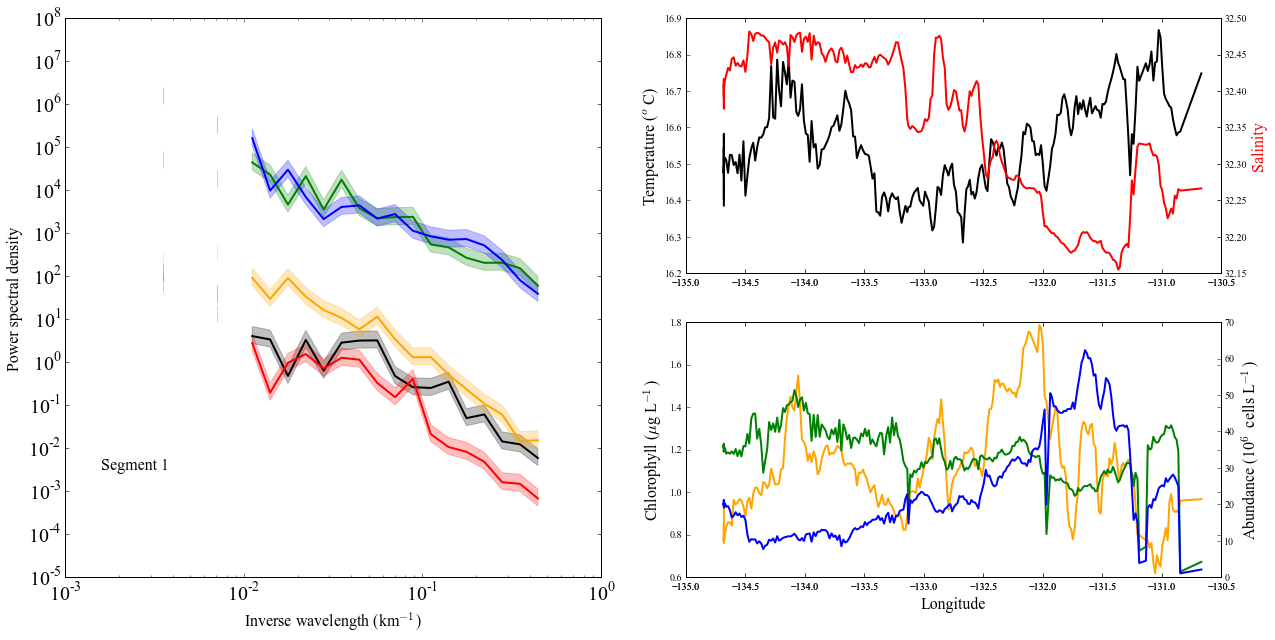

In [ ]:
fig1 = plt.figure(1, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_1'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig1.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 1', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_1']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_1'])*c[0],np.abs(binned['ocean_tmp_1'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_1']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_1'])*c[0],np.abs(binned['salinity_1'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_1']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_1'])*c[0],np.abs(binned['picoeuk_1'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_1']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_1'])*c[0],np.abs(binned['synecho_1'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_1']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_1'])*c[0],np.abs(binned['pico_1'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_1']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_1'])*c[0],np.abs(binned['chl_1'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][1]
b = segments['end'][1]

sub2 = fig1.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig1.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig1.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig1.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig1.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_1_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

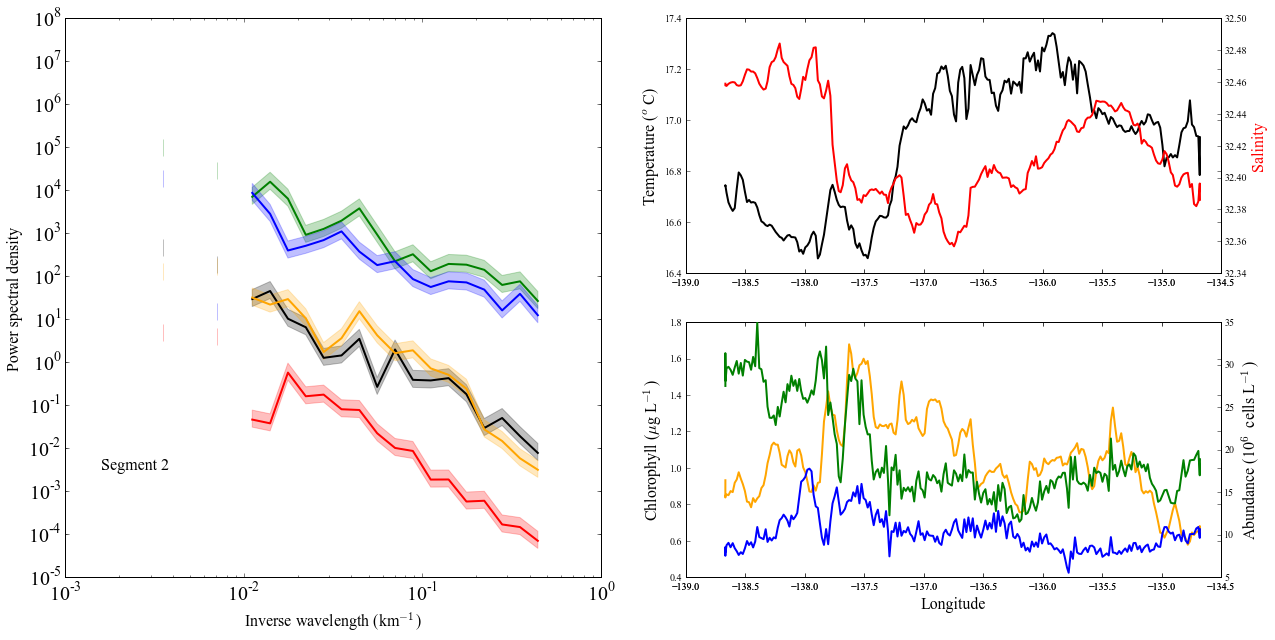

In [ ]:
fig2 = plt.figure(2, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_2'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig2.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 2', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_2']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_2'])*c[0],np.abs(binned['ocean_tmp_2'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_2']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_2'])*c[0],np.abs(binned['salinity_2'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_2']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_2'])*c[0],np.abs(binned['picoeuk_2'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_2']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_2'])*c[0],np.abs(binned['synecho_2'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_2']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_2'])*c[0],np.abs(binned['pico_2'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_2']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_2'])*c[0],np.abs(binned['chl_2'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][2]
b = segments['end'][2]

sub2 = fig2.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig2.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig2.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig2.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig2.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_2_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig3 = plt.figure(3, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_3'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig3.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 3', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_3']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_3'])*c[0],np.abs(binned['ocean_tmp_3'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_3']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_3'])*c[0],np.abs(binned['salinity_3'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_3']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_3'])*c[0],np.abs(binned['picoeuk_3'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_3']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_3'])*c[0],np.abs(binned['synecho_3'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_3']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_3'])*c[0],np.abs(binned['pico_3'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_3']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_3'])*c[0],np.abs(binned['chl_3'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][3]
b = segments['end'][3]

sub2 = fig3.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig3.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig3.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig3.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig3.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_3_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig4 = plt.figure(4, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_4'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig4.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 4', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-6, 10**7])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_4']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_4'])*c[0],np.abs(binned['ocean_tmp_4'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_4']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_4'])*c[0],np.abs(binned['salinity_4'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_4']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_4'])*c[0],np.abs(binned['picoeuk_4'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_4']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_4'])*c[0],np.abs(binned['synecho_4'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_4']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_4'])*c[0],np.abs(binned['pico_4'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_4']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_4'])*c[0],np.abs(binned['chl_4'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][4]
b = segments['end'][4]

sub2 = fig4.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig4.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig4.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig4.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig4.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_4_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig5 = plt.figure(5, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_5'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig5.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 5', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_5']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_5'])*c[0],np.abs(binned['ocean_tmp_5'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_5']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_5'])*c[0],np.abs(binned['salinity_5'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_5']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_5'])*c[0],np.abs(binned['picoeuk_5'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_5']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_5'])*c[0],np.abs(binned['synecho_5'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_5']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_5'])*c[0],np.abs(binned['pico_5'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_5']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_5'])*c[0],np.abs(binned['chl_5'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][5]
b = segments['end'][5]

sub2 = fig5.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig5.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig5.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig5.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig5.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_5_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig6 = plt.figure(6, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_6'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig6.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 6', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_6']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_6'])*c[0],np.abs(binned['ocean_tmp_6'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_6']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_6'])*c[0],np.abs(binned['salinity_6'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_6']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_6'])*c[0],np.abs(binned['picoeuk_6'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_6']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_6'])*c[0],np.abs(binned['synecho_6'])*c[1], color='b', alpha = 0.25)
#sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_6']), 'cyan', lw=2)
#sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_6'])*c[0],np.abs(binned['pico_6'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_6']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_6'])*c[0],np.abs(binned['chl_6'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][6]
b = segments['end'][6]

sub2 = fig6.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig6.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig6.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig6.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
#ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig6.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_6_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig7 = plt.figure(7, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_7'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig7.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 7', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_7']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_7'])*c[0],np.abs(binned['ocean_tmp_7'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_7']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_7'])*c[0],np.abs(binned['salinity_7'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_7']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_7'])*c[0],np.abs(binned['picoeuk_7'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_7']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_7'])*c[0],np.abs(binned['synecho_7'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_7']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_7'])*c[0],np.abs(binned['pico_7'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_7']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_7'])*c[0],np.abs(binned['chl_7'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][7]
b = segments['end'][7]

sub2 = fig7.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig7.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig7.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig7.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig7.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_7_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig8 = plt.figure(8, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_8'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig8.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 8', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_8']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_8'])*c[0],np.abs(binned['ocean_tmp_8'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_8']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_8'])*c[0],np.abs(binned['salinity_8'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_8']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_8'])*c[0],np.abs(binned['picoeuk_8'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_8']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_8'])*c[0],np.abs(binned['synecho_8'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_8']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_8'])*c[0],np.abs(binned['pico_8'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_8']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_8'])*c[0],np.abs(binned['chl_8'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][8]
b = segments['end'][8]

sub2 = fig8.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig8.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig8.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig8.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig8.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_8_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

In [ ]:
fig9 = plt.figure(9, figsize=(18, 9), dpi = 600)

# get the confidence intervals for the spectra
tmp = binned['salinity_9'].values

probability = 0.95
alfa = 1 - probability
#P is the number of estimates from the binning
#and also the degree of freedom.
P = len((np.where(np.isfinite(tmp)))[0])
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c

# make figure
sub1 = fig9.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 9', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-5, 10**8])

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_9']), 'k', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['ocean_tmp_9'])*c[0],np.abs(binned['ocean_tmp_9'])*c[1], color='k', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_9']), 'r', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['salinity_9'])*c[0],np.abs(binned['salinity_9'])*c[1], color='r', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_9']), 'g', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['picoeuk_9'])*c[0],np.abs(binned['picoeuk_9'])*c[1], color='g', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_9']), 'b', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['synecho_9'])*c[0],np.abs(binned['synecho_9'])*c[1], color='b', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_9']), 'cyan', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['pico_9'])*c[0],np.abs(binned['pico_9'])*c[1], color='cyan', alpha = 0.25)
sub1.loglog(1./binned['k_mid'], np.abs(binned['chl_9']), 'orange', lw=2)
sub1.fill_between(1./binned['k_mid'], np.abs(binned['chl_9'])*c[0],np.abs(binned['chl_9'])*c[1], color='orange', alpha = 0.25)


sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][9]
b = segments['end'][9]

sub2 = fig9.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig9.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig9.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Chlorophyll ($\mu$g L$^{-1}$)', fontsize = 16)

ax3 = fig9.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig9.savefig('/Users/archie/Documents/work/KM1304_lengthscales/figures/KM1304_9_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl